In [9]:
##########################
#Code the Bezier Density Network - Constrained
##########################

In [10]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle as pk
plt.rcParams["figure.figsize"]=15,15

In [11]:
#define the toy model inverse problem
def inv_model(t):
    #create a an array of uniform random variables
    ##################
    #Alternative distributon shapes
    #eps = np.random.uniform(-0.1,0.1,t.shape)
    #eps = np.random.gamma(2,2,t.shape)/160
    ##################
    eps = np.random.normal(0,1/10,t.shape)    
    return t + 0.3*np.sin(2*np.pi*t) + eps

def generate_data_model(n):
    #return a random inverse pick for each x
    X = np.random.uniform(0,1,(n*10))
    t = np.random.uniform(0,1,(n))
    Y = inv_model(X)
    #sort by Y
    ind=np.argsort(Y)
    X=X[ind]
    Y=Y[ind]
    Xret=[]
    Yret=[]
    #now for each x pick an X and Y    
    for i in range(len(t)):
        idx = np.argmax(Y>t[i])
        Xret.append(X[idx])
        Yret.append(Y[idx])

    return (torch.Tensor(np.array(Xret)).unsqueeze(1),torch.Tensor(np.array(Yret)).unsqueeze(1))
    
#we create a dataset
version='gaussian'
X_train = np.random.uniform(0,1,(4000))
Y_train = torch.Tensor(inv_model(X_train)).unsqueeze(1)
X_train = torch.Tensor(X_train).unsqueeze(1)

X_val = np.random.uniform(0,1,(4000))
Y_val = torch.Tensor(inv_model(X_val)).unsqueeze(1)
X_val = torch.Tensor(X_val).unsqueeze(1)

X_test = np.random.uniform(0,1,(4000))
Y_test = torch.Tensor(inv_model(X_test)).unsqueeze(1)
X_test = torch.Tensor(X_test).unsqueeze(1)

In [12]:
#normalise the data
train_min = Y_train.min()
train_max = Y_train.max()

def normlise(y):
    return (y-train_min)/(train_max-train_min)

def denormlise(y):
    return y*(train_max-train_min)+train_min

Y_train = normlise(Y_train)
Y_val = normlise(Y_val)
Y_test = normlise(Y_test)

In [13]:
# the score functions
#average negative log predictive density (NLPD) (Good, 1952)
def NLPD(x_obs,y_obs,p):
    #compute the pdfs for each y|x
    t = x_obs.view(-1)
    prob = bezier_pdf(t,p).view(-1,1).numpy()
    #set the minimum to 1/n, taking n=4000 to avoid infinite predictions
    prob = (prob<1/p.shape[0])*1/p.shape[0]+prob*(prob>=1/p.shape[0])
    return -np.sum(np.log(prob))/prob.shape[0]

#MAE to the median of the distribution 
def MAE(x_obs,y_obs,p):
    medians = denormlise(bezier_inv_cdf(0.5*torch.ones(p.shape[0]).view(-1),p).view(-1,1)).numpy()
    return np.sum(np.abs(medians-x_obs.view(-1,1).numpy()))/medians.shape[0]

#Continuous Ranked Probability Score or the CRPS. The CRPS (Gneiting & Raftery, 2004)
def CRPS(x_obs,y_obs,p):
    #resolution 
    res = 1000
    #we get the cdf values at each point
    cdf = None
    for i in range(res):
        this_cdf = bezier_cdf((i/(res-1))*torch.ones(p.shape[0]).view(-1),p).view(-1,1).numpy()
        if (cdf is None):
            cdf=this_cdf
        else:
            cdf=np.concatenate((cdf,this_cdf),axis=1)
    #compute the left hand side and right hand sides of the cdf
    cdf_lhs = cdf*cdf*(cdf<=x_obs.view(-1,1).numpy())
    cdf_rhs = (cdf-1)*(cdf-1)*(cdf>=x_obs.view(-1,1).numpy())
    
    #now compute the approx area using trapezium rule
    cdf_lhs = np.sum(cdf_lhs[:,:-1] +cdf_lhs[:,1:],1)/(res*2)
    cdf_rhs = np.sum(cdf_rhs[:,:-1] +cdf_rhs[:,1:],1)/(res*2)
    crps = np.sum(cdf_lhs+cdf_rhs)/p.shape[0]
    return crps


In [14]:
#### Define the Bezier functions
def bezier(n,t):
    l = t.shape[0]
    b = torch.zeros(l,n+1).to(device)
    for i in range(n+1):
        b[:,i] = (math.factorial(n)/(math.factorial(i)*math.factorial(n-i)))*(t**i)*(1-t)**(n-i)
    return b

def bezier_pdf(t,p):
    n = int(p.shape[1]/2)
    b = bezier(n-2,t)     
    x_delta = p[:,1:n] - p[:,:(n-1)]
    z_delta = p[:,(n+1):] - p[:,n:-1]
    denom=torch.sum(b*x_delta,1)
    prob = torch.sum(b*z_delta,1)/denom
    return prob

def bezier_cdf(t,p):
    n = int(p.shape[1]/2)
    z = p[:,n:]
    x = p[:,:n]
    b = bezier(n-1,t)
    prob = torch.sum(b*z,1)
    return prob

def bezier_inv_cdf(probs,p):
    #now we need to find the t values that correspond to these selections
    l = p.shape[0]
    threshold =0.000001
    max_loops=200
    t_min=torch.zeros(l).to(device)
    t_max=torch.ones(l).to(device)
    while((max_loops>0) and (torch.sum(t_max-t_min)>=threshold)):
        max_loops-=1
        t_mid = (t_min+t_max)/2
        prob_mid = bezier_cdf(t_mid,p)
        t_max = t_max*(probs>=prob_mid)+t_mid*(probs<prob_mid)
        t_min = t_min*(probs<prob_mid)+t_mid*(probs>=prob_mid)
    #now we have the t values convert these into x's and return    
    x=t_mid
    return x

def bezier_rnd(p):
    #takes a vector of bezier curves and returns random selections
    #first we get random selections in 0,1
    l = p.shape[0]
    probs = torch.FloatTensor(l).uniform_(0.0, 1.0).to(device)
    #now we need to find the t values that correspond to these selections
    #set numerical convergence thresholds
    threshold =0.000001
    max_loops=200
    t_min=torch.zeros(l).to(device)
    t_max=torch.ones(l).to(device)
    while((max_loops>0) and (torch.sum(t_max-t_min)>=threshold)):
        max_loops-=1
        t_mid = (t_min+t_max)/2
        prob_mid = bezier_cdf(t_mid,p)
        t_max = t_max*(probs>=prob_mid)+t_mid*(probs<prob_mid)
        t_min = t_min*(probs<prob_mid)+t_mid*(probs>=prob_mid)
    #now we have the t values convert these into x's and return    
    x=t_mid
    return x

def bezier_x(p,t):
    #given a t return corresponding x under bezier p
    n = int(p.shape[1]/2)
    b = bezier(n-1,t)
    return torch.sum(b*p[:,:n],1)

def bezier_t(p,x):
    l = x.shape[0]
    #given an x return correspoding t under bezier p
    #interpolate
    threshold =0.0001
    max_loops=50
    t_min=torch.zeros(l).to(device)
    t_max=torch.ones(l).to(device)
    while((max_loops>0) and (torch.sum(t_max-t_min)>=threshold)):
        max_loops-=1
        t_mid = (t_min+t_max)/2
        x_mid = bezier_x(p,t_mid)
        t_max = t_max*(x[:,0]>=x_mid)+t_mid*(x[:,0]<x_mid)
        t_min = t_min*(x[:,0]<x_mid)+t_mid*(x[:,0]>=x_mid)
    return t_mid

GPU not available, CPU used
epoch = 0 train loss = -0.011684289202094078 validation loss = -0.014894137158989906
epoch = 1 train loss = -0.036194995045661926 validation loss = -0.04525094851851463
epoch = 2 train loss = -0.06482086330652237 validation loss = -0.0734124630689621
epoch = 3 train loss = -0.09133181720972061 validation loss = -0.09991293400526047
epoch = 4 train loss = -0.11543124914169312 validation loss = -0.12431954592466354
epoch = 5 train loss = -0.14436686038970947 validation loss = -0.15089687705039978
epoch = 6 train loss = -0.17029105126857758 validation loss = -0.17839181423187256
epoch = 7 train loss = -0.19522790610790253 validation loss = -0.2052832990884781
epoch = 8 train loss = -0.21970541775226593 validation loss = -0.23122242093086243
epoch = 9 train loss = -0.23564156889915466 validation loss = -0.25587689876556396
epoch = 10 train loss = -0.2718213200569153 validation loss = -0.2796945571899414
epoch = 11 train loss = -0.2953698933124542 validation loss

epoch = 101 train loss = -0.6859409213066101 validation loss = -0.6663278341293335
epoch = 102 train loss = -0.666782557964325 validation loss = -0.6659897565841675
epoch = 103 train loss = -0.6753416657447815 validation loss = -0.6650514602661133
epoch = 104 train loss = -0.6683656573295593 validation loss = -0.6670699119567871
epoch = 105 train loss = -0.6942191123962402 validation loss = -0.6664367318153381
epoch = 106 train loss = -0.6568343639373779 validation loss = -0.6666632294654846
epoch = 107 train loss = -0.6920722723007202 validation loss = -0.6658746004104614
epoch = 108 train loss = -0.665535032749176 validation loss = -0.6673153042793274
epoch = 109 train loss = -0.6852696537971497 validation loss = -0.668164074420929
epoch = 110 train loss = -0.6974526643753052 validation loss = -0.6683884263038635
epoch = 111 train loss = -0.7002527117729187 validation loss = -0.6667912602424622
epoch = 112 train loss = -0.673818826675415 validation loss = -0.6667523980140686
epoch = 

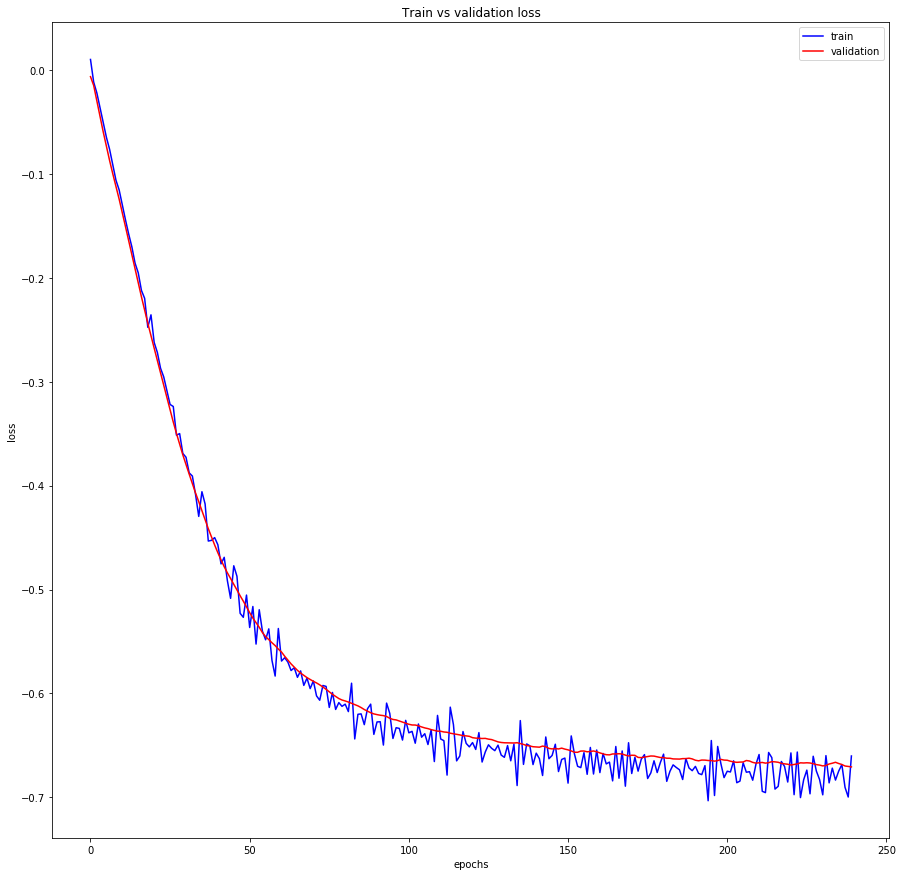

In [15]:
#######################
#### Bezier Density Network to fit the inverse function
#######################
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
def Bezier_Output_Layer(x,finetune):
    #we convert the final layer of the network into the Bezier outputs
    with torch.no_grad():
        #get the number of control points, n
        n=int((x.shape[1]+2)/2)
        l = x.shape[0]
    #set the x values of the control points
    p_x = x[:,:(n-1)] 
    #ensure positive and 0 to 1 ascending using cumsum
    p_x =torch.exp(p_x)
    p_x = torch.cumsum(p_x,1)/torch.sum(p_x,1).view(-1,1)
    #create the zero values
    p_x0 = torch.zeros((l,1)).to(device)
    p_z0 = torch.zeros((l,1)).to(device)
    #set the z values of the control points
    p_z = x[:,(n-1):]      
    #constrain the z's, ensuring positve and 0 to 1 ascending using cumsum
    p_z = torch.exp(p_z)
    p_z = torch.cumsum(p_z,1)/torch.sum(p_z,1).view(-1,1)
    #Concatenate together the output parameters
    p_x = torch.cat((p_x0,p_x),1)
    p_z = torch.cat((p_z0,p_z),1)    
    p = torch.cat((p_x,p_z),1)
    return p

def Bezier_loss(x,y):
    #we compute the MDN loss using a custom loss function
    with torch.no_grad():
        n=int(x.shape[1]/2)
        batch_len=x.shape[0]
    t=y.view(-1)
    #we take the finite difference of the CDF
    prob = (-bezier_cdf(t-0.0001,x)+bezier_cdf(t+0.0001,x))/.0002
    #compute the log - we include the boolean term to avoid log(0)
    prob = torch.log((prob)*(prob>0)+(prob<=0))
    #compute the negative average of the log loss
    loss =-torch.sum(prob )/x.shape[0]
    return loss

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.finetune=False
        self.regressor = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            #the number of control points = 50 here
            nn.Linear(50, (50*2-2))
        )
    def set_finetune(self,finetune):
        self.finetune = finetune
        
    def forward(self, x):
        x = self.regressor(x)
        #apply the custom output layer
        return Bezier_Output_Layer(x,self.finetune)

net = Net().to(device)
params = list(net.parameters())
#apply the bezier loss
criterion = Bezier_loss
optimizer = optim.Adam(net.parameters(),lr=0.01,weight_decay=0.00)
#store the results as we train
loss_v=[]
loss_t=[]
    
traindata = TensorDataset( X_train,Y_train )
dataloader = DataLoader(traindata, batch_size= 2000, shuffle=True) 

for epoch in range(120):
    net.train()
    ######NOTE THAT WE SWAP THE X AND Y HERE ######### 
    for batch_idx, (Y, X) in enumerate(dataloader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = net(X.to(device))
        loss = criterion(outputs, Y.to(device))
        loss.backward()
        optimizer.step()
        loss_t.append(loss.item())     
        #evaluate the loss on validation set    
        loss_v.append(criterion(net(Y_val.to(device)), X_val.to(device)).item())
    print(f"epoch = {epoch} train loss = {loss_t[-1]} validation loss = {loss_v[-1]}")
        
print('Finished Training')
plt.plot(loss_t, "-b", label="train")
plt.plot(loss_v , "-r", label="validation")
plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Train vs validation loss")
plt.show()

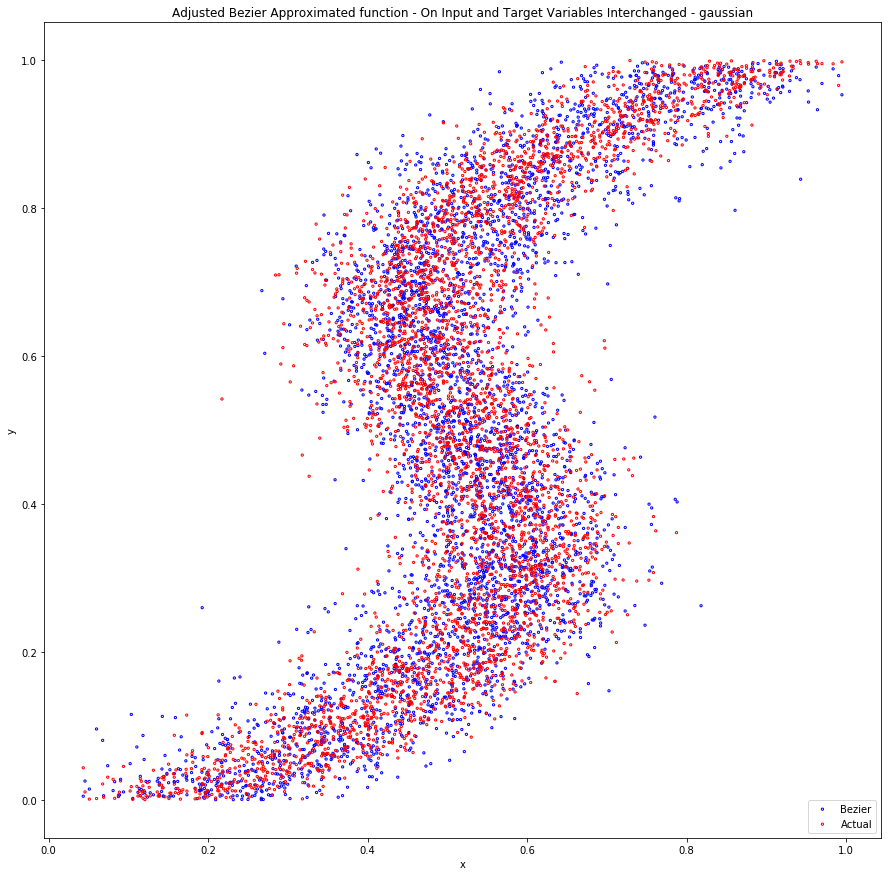

In [16]:
#generate a simple scatter plot
Y_test_new = probs = torch.FloatTensor(4000,1).uniform_(0.0, 1.0).to(device)
X_test_predict_Bezier = net(Y_test.to(device)).detach()#.numpy()
X_test_predict = bezier_rnd(X_test_predict_Bezier)
plt.scatter(Y_test.cpu().numpy(),X_test_predict.cpu().numpy(), color='blue', marker='o',s=5,facecolors='none', label="Bezier")
plt.scatter(Y_test.cpu().numpy(),X_test.cpu().numpy(), color='red', marker='o',s=5,facecolors='none', label="Actual")
plt.legend(loc="lower right")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Adjusted Bezier Approximated function - On Input and Target Variables Interchanged - " + version)
plt.show()    

10


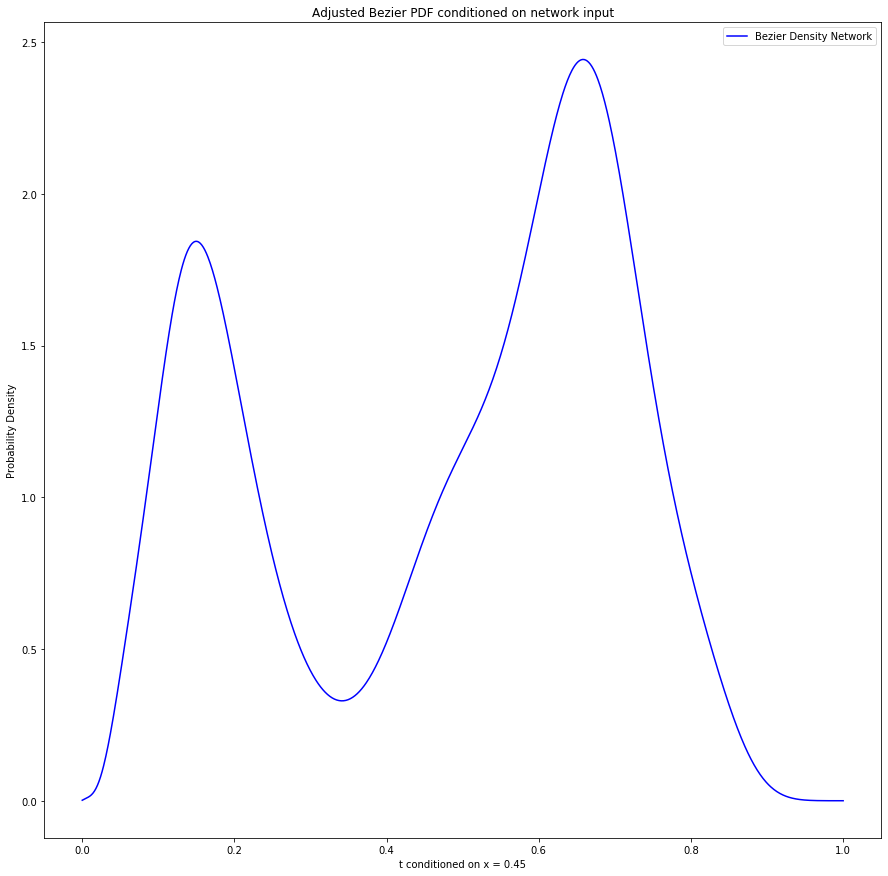

In [17]:
#plot an example bezier for a given x (eval_at)
t = torch.linspace(0,1,1000)
eval_at = 0.43
for i in range(Y_test.shape[0]):
    if((Y_test[i]>eval_at) and (Y_test[i]<eval_at+.02)):
        print(i)
        break
num = i
p = X_test_predict_Bezier[num,:].view(1,-1)
x = Y_test[num]
x_val = bezier_pdf(t,p)
plt.plot(t,x_val.cpu(), color='blue', label="Bezier Density Network")
plt.legend(loc="upper right")
plt.xlabel("t conditioned on x = " + str(round(x.item(),2)))
plt.ylabel("Probability Density")
plt.title("Adjusted Bezier PDF conditioned on network input")
plt.show()

NLPD = -0.6488889434514101
MAE = 0.21726139831542968
CRPS = 0.09981986999511719


Text(0.5, 1.0, 'BDN Constrained - gaussian')

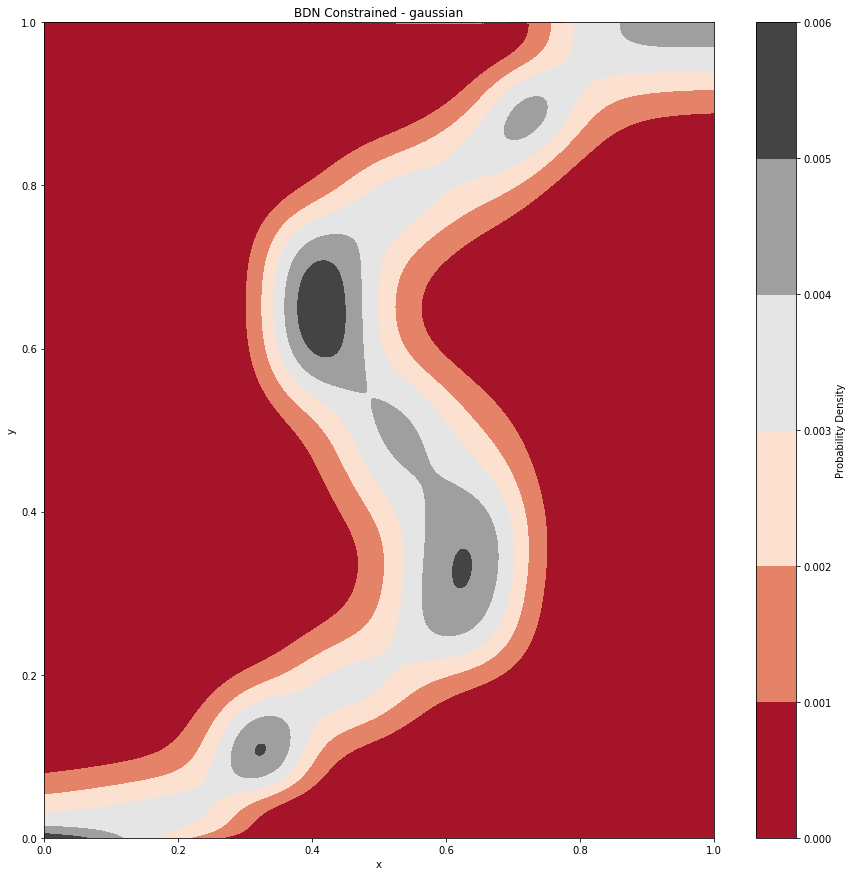

In [18]:
p = net(Y_test.to(device)).detach()
#compute the scores
print(f"NLPD = {NLPD(X_test,Y_test,p)}")
print(f"MAE = {MAE(X_test,Y_test,p)}")
print(f"CRPS = {CRPS(X_test,Y_test,p)}")
#density plot
Y_density = torch.linspace(0.0, 1.0,1000).view(-1,1).to(device)
X_density = torch.linspace(0.0, 1.0,1000).view(-1,1).to(device)
X_density_Bezier = net(Y_density.to(device)).detach()#.numpy()
X, Y = torch.meshgrid(X_density.view(-1), Y_density.view(-1))
Z = torch.zeros(X.shape)
for i in range(1000):
    Z[:,i] = bezier_pdf(X[i,:],X_density_Bezier)
    Z[:,i] = Z[:,i]*(Z[:,i]>0)
    Z[:,i] = Z[:,i]/torch.sum(Z[:,i])
plt.contourf(X, Y, Z, 5, cmap='RdGy')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Probability Density', rotation=90)
plt.xlabel("x")
plt.ylabel("y")
plt.title("BDN Constrained - " + version)